In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

def preprocess_df(df):
    """Rename the profile column and parse list columns."""
    df = df.copy()
    if 'Unnamed: 0' in df.columns:
        df = df.rename(columns={'Unnamed: 0': 'profile'})
    cols = [
        'interaction_time', 'interaction_num_turns', 'interaction_total_char_length',
        'accuracy', 'AUCROC', 'correct_prob',
        'accuracy_relative', 'AUCROC_relative', 'correct_prob_relative'
    ]
    for col in cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

def plot_metric_over_interactions(df, metric, ax=None):
    """Plot a metric over interactions for each profile."""
    ax = ax or plt.gca()
    for _, row in df.iterrows():
        turns = row['interaction_num_turns']
        values = row[metric]
        ax.plot(turns, values, marker='o', label=f'Profile {row["profile"]}')
    ax.set_xlabel('interaction_num_terms')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} over interactions')
    ax.legend()

def compare_profiles(df, metric, turn=-1, ax=None):
    """Compare profiles for a given metric at a specific interaction step."""
    ax = ax or plt.gca()
    values = []
    labels = []
    for _, row in df.iterrows():
        data = row[metric]
        val = data[turn] if isinstance(data, list) else data
        labels.append(row['profile'])
        values.append(val)
    ax.bar(labels, values)
    ax.set_xlabel('profile')
    ax.set_ylabel(metric)
    step = turn if turn >= 0 else 'final'
    ax.set_title(f'{metric} at step {step}')
    plt.xticks(rotation=45)
    return pd.DataFrame({'profile': labels, metric: values})


def average_metric_over_turns(df, metric):
    """Return a DataFrame with the mean and std of `metric` across profiles."""
    metrics_by_turn = {}
    for _, row in df.iterrows():
        turns = row['interaction_num_turns']
        values = row[metric]
        for t, val in zip(turns, values):
            metrics_by_turn.setdefault(t, []).append(val)
    turns_sorted = sorted(metrics_by_turn)
    mean_vals = [np.mean(metrics_by_turn[t]) for t in turns_sorted]
    std_vals = [np.std(metrics_by_turn[t]) for t in turns_sorted]
    return pd.DataFrame({'interaction_num_turns': turns_sorted,
                         'mean': mean_vals,
                         'std': std_vals})

def plot_metric_avg_over_interactions(df, metric, shade_std=False, ax=None):
    """Plot the average of a metric across profiles over interactions."""
    ax = ax or plt.gca()
    stats = average_metric_over_turns(df, metric)
    ax.plot(stats['interaction_num_turns'], stats['mean'], marker='o')
    if shade_std:
        ax.fill_between(stats['interaction_num_turns'],
                        stats['mean'] - stats['std'],
                        stats['mean'] + stats['std'],
                        alpha=0.3)
    ax.set_xlabel('interaction_num_turns')
    ax.set_ylabel(metric)
    ax.set_title(f'Average {metric} over interactions')
    return stats

def compare_dfs_average(dfs, labels, metric, shade_std=False, ax=None):
    """Plot averaged metric for multiple dataframes on the same axes."""
    ax = ax or plt.gca()
    results = []
    for df, label in zip(dfs, labels):
        stats = average_metric_over_turns(df, metric)
        ax.plot(stats['interaction_num_turns'], stats['mean'], marker='o', label=label)
        if shade_std:
            ax.fill_between(stats['interaction_num_turns'],
                            stats['mean'] - stats['std'],
                            stats['mean'] + stats['std'],
                            alpha=0.3)
        stats['label'] = label
        results.append(stats)
    ax.set_xlabel('interaction_num_turns')
    ax.set_ylabel(metric)
    ax.set_title(f'Average {metric} over interactions')
    ax.legend()
    return results

In [22]:
fp_1_candidate = "/home/gathomp3/deep_learning/EIG_elicitation/GATE-forked/model_model_results/website_preferences/gpt-4_at_end_0_1_candidate.csv"
df_1_candidate = preprocess_df(pd.read_csv(fp_1_candidate))

fp_5_candidate = "/home/gathomp3/deep_learning/EIG_elicitation/GATE-forked/model_model_results/website_preferences/gpt-4_at_end_0_5_candidate.csv"
df_5_candidate = preprocess_df(pd.read_csv(fp_5_candidate))

fp_10_candidate = "/home/gathomp3/deep_learning/EIG_elicitation/GATE-forked/model_model_results/website_preferences/gpt-4_at_end_0_10_candidate.csv"
df_10_candidate = preprocess_df(pd.read_csv(fp_10_candidate))

,interaction_num_turns,mean,std
0,0,0.55000,0.025000
1,1,0.57750,0.078022
2,2,0.64125,0.057500
3,3,0.64500,0.049749
4,4,0.65500,0.032930
5,5,0.64875,0.035663


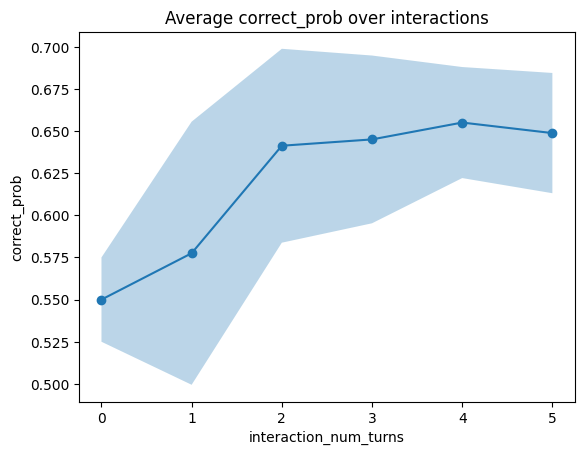

In [26]:
plot_metric_avg_over_interactions(df_10_candidate, 'correct_prob', shade_std=True)

In [33]:
df_1_candidate.columns

Index(['profile', 'interaction_time', 'interaction_num_turns',
       'interaction_total_char_length', 'accuracy', 'AUCROC', 'correct_prob',
       'accuracy_relative', 'AUCROC_relative', 'correct_prob_relative',
       'question_mode', 'task', 'engine', 'seed'],
      dtype='object')

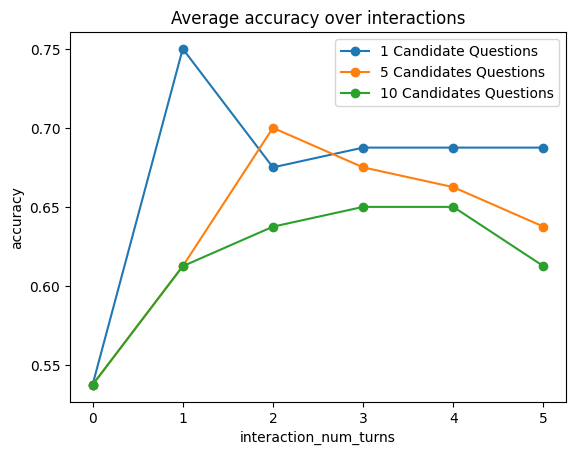

In [34]:
plot = compare_dfs_average([df_1_candidate, df_5_candidate, df_10_candidate], 
                     ['1 Candidate Questions', '5 Candidates Questions', '10 Candidates Questions'], 
                     'accuracy', 
                     shade_std=False)

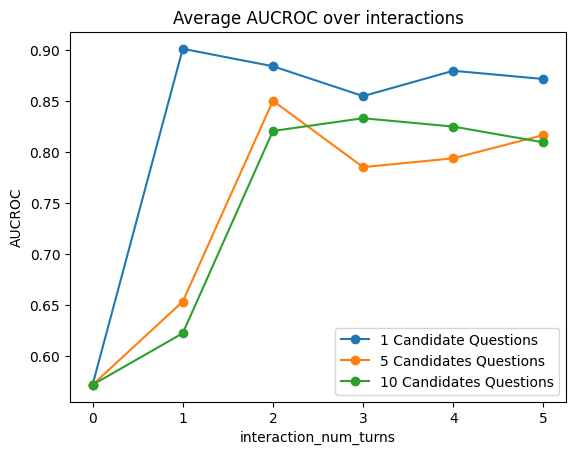

In [35]:
plot = compare_dfs_average([df_1_candidate, df_5_candidate, df_10_candidate], 
                     ['1 Candidate Questions', '5 Candidates Questions', '10 Candidates Questions'], 
                     'AUCROC', 
                     shade_std=False)